<h1><center>Тестовое задание Devim</center></h1>

[Ссылка на вакансию](https://spb.hh.ru/vacancy/41436973)

### Постановка задачи

Необходимо на основе предоставленных данных построить модель для предсказания
целевой переменной. Сделать описание проделанных шагов
* Анализ данных
* Фильтрация
* Преобразование переменных
* Моделирование
* Оценка качества модели
Обоснование выбранной метрики качества. Подробно описать способ оценки качества
построенной модели.

### Целевая переменная
expert(целевая переменная) - решение, которое принято по заявке (0 - одобрено, 1 - отклонено)

### Переменные, характеризующие кредитную историю клиента

|переменная|описание|
|---|---|
|closed_cred_sum|сумма, которую клиент выплатил по ранее взятым и закрытым кредитам|
|closed_creds|количество закрытых кредитов|
|active_cred_sum_overdue|суммарная задолженность по активным кредитам|
|active_cred_sum|сумма всех активных кредитов|
|active_cred_day_overdue|суммарная просрочка в днях по всем активным кредитам|
|active_cred_max_overdue|максимальная сумма просроченной задолженности по активным кредитам|

### Переменные характеризующие клиента

|переменная|описание|
|---|---|
|age|возраст|
|gender|пол|
|region|регион|
|month_income|ежемесячный доход|

### Переменные, характеризующие кредит, по которому нужно сделать прогноз

|переменная|описание|
|---|---|
|first_loan|сумма, которую клиент хочет получить в кредит (из заявки)|
|first_days_quant|срок, на которую клиент хочет взять кредит|
|loan_cost_all|одобренная клиенту сумма кредита|
|order_date|дата подачи заявки на получение кредита|
|cost_all|сумма всех выплат по одобренному кредиту|
|order_id|id заявки|
|client_id|id клиента|

---

### Решение

#### 1. импорт библиотек, путь к данным

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from tqdm import tqdm_notebook
import gc
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from lightgbm import LGBMClassifier
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score 
from scipy import stats

PATH_TO_DATA = 'data.csv'
SEP = ';'
SEED = 13

#### 2. загрузка данных, приведение колонки с датой к типу datetime

In [2]:
# загружаем данные
df = pd.read_csv(PATH_TO_DATA, sep = SEP)

# приводим колонку с датой к типу datetime
df['order_date'] = df['order_date'].astype('datetime64')

#### 3. первичный анализ

In [3]:
print('Пропущенные значения:')
for i, (col, nancount) in enumerate(df[df.columns[df.isna().any()]].isna().sum().items()):
    print('\t{}) у {} клиентов отсутвует {}'.format(i+1, nancount, col))

Пропущенные значения:
	1) у 19 клиентов отсутвует first_loan


In [4]:
# кредитная история
client_credit_history_cols = ['closed_cred_sum', 'closed_creds',\
                        'active_cred_sum_overdue','active_cred_sum',\
                        'active_cred_day_overdue', 'active_cred_max_overdue']
# характеристики клиента
client_cols = ['age', 'gender', 'region', 'month_income']
# характеристики кредита
credit_cols = ['order_date', 'cost_all','order_id', 'client_id', 'expert']

In [5]:
def _exclude_outliers(val):
    ''' Исключает выбросы с помощью интерквартильного размаха '''
    q25, q75 =val.quantile([.25, .75])
    iqr = q75-q25
    return val.between(q25-1.5*iqr, q75+1.5*iqr)

In [6]:
print(str.upper('размах значений\n'))
for i, (name, columns_group) in enumerate(zip(('кредитная история клиента', 'характеристики клиента', 'характеристики кредита'),\
                                              (client_credit_history_cols, client_cols, credit_cols))):
    tab = df[columns_group].agg({'min', 'max'}).T.rename(columns = {'min':'минимум', 'max':'максимум'})
    tab['число ун.зн.'] = df[columns_group].nunique()
    tab.index.name = 'название признака'
    print('\t{}) {}'.format(i+1, name))
    print('-------------------------------------------------------------------------')
    print(tab)
    print('-------------------------------------------------------------------------\n')

РАЗМАХ ЗНАЧЕНИЙ

	1) кредитная история клиента
-------------------------------------------------------------------------
                         минимум     максимум  число ун.зн.
название признака                                          
closed_cred_sum              0.0  44574209.38         25314
closed_creds                 0.0       563.00           166
active_cred_sum_overdue      0.0  33030999.24         20189
active_cred_sum              0.0  22731655.24         25138
active_cred_day_overdue      0.0     21927.00          4719
active_cred_max_overdue      0.0  21701655.24         21721
-------------------------------------------------------------------------

	2) характеристики клиента
-------------------------------------------------------------------------
                   минимум  максимум  число ун.зн.
название признака                                 
age                   18.0      99.0            68
gender                 0.0       1.0             2
region             

In [7]:
# излишняя точность кредитной истории
df.loc[:, client_credit_history_cols] = df[client_credit_history_cols].round()

In [8]:
num_cols =['closed_cred_sum','active_cred_sum_overdue', 'age',
           'active_cred_sum', 'active_cred_day_overdue',
           'active_cred_max_overdue', 'month_income', 'loan_cost_all',
           'first_days_quant', 'first_loan', 'cost_all', 'closed_creds']

#### числовые признаки

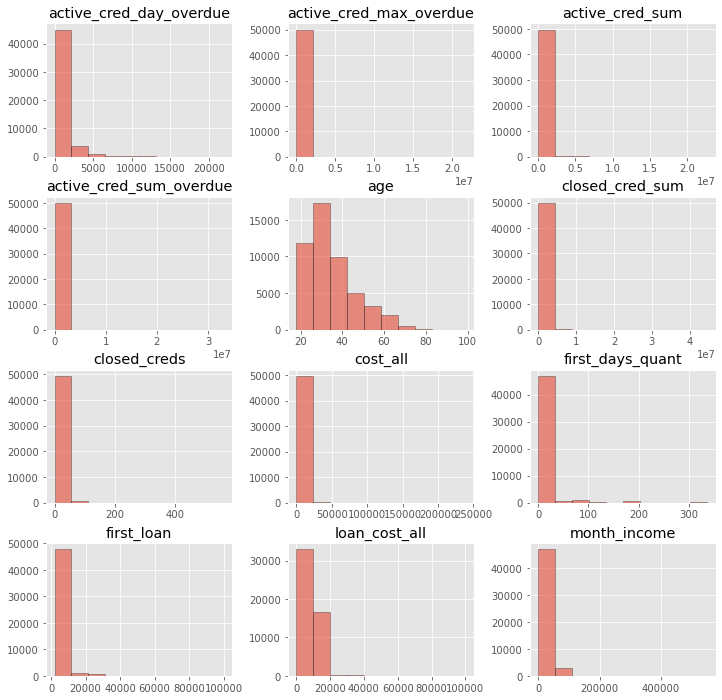

In [9]:
df[num_cols].hist(edgecolor = 'black', alpha = .6, figsize = (12, 12));

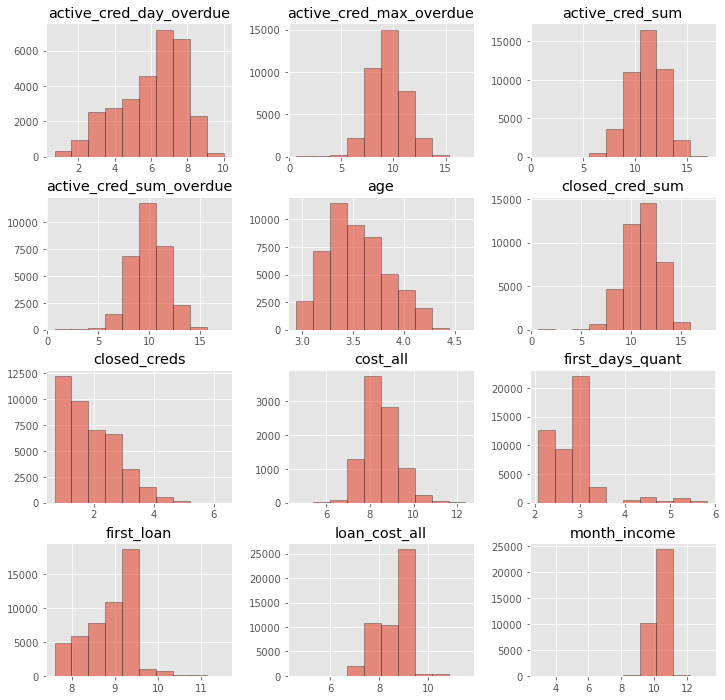

In [10]:
df_c =df.copy()
df_c[num_cols] = df_c[num_cols].replace({0:np.nan}).apply(np.log1p)
df_c[num_cols].hist(edgecolor = 'black', alpha = .6, figsize = (12, 12));

In [11]:
OUTLIER_TRESHOLD = .01
to_exclude_outlier_cols = []
print('{:<23} | {}'.format('признак', 'доля выбросов'))
print('---------------------------------------')
for col in num_cols:
    outlier_share = 1-_exclude_outliers(df_c[col].fillna(0)).mean()    
    print('{:<23} | {:.2%}'.format(col, outlier_share))
    if outlier_share<OUTLIER_TRESHOLD:
        to_exclude_outlier_cols.append(col)

признак                 | доля выбросов
---------------------------------------
closed_cred_sum         | 18.41%
active_cred_sum_overdue | 0.00%
age                     | 0.12%
active_cred_sum         | 9.57%
active_cred_day_overdue | 0.00%
active_cred_max_overdue | 23.82%
month_income            | 0.00%
loan_cost_all           | 0.07%
first_days_quant        | 6.22%
first_loan              | 1.75%
cost_all                | 18.49%
closed_creds            | 0.24%


In [12]:
# удалим выбросы
df_c = df_c[df_c[to_exclude_outlier_cols].fillna(0).apply(_exclude_outliers).all(1)]

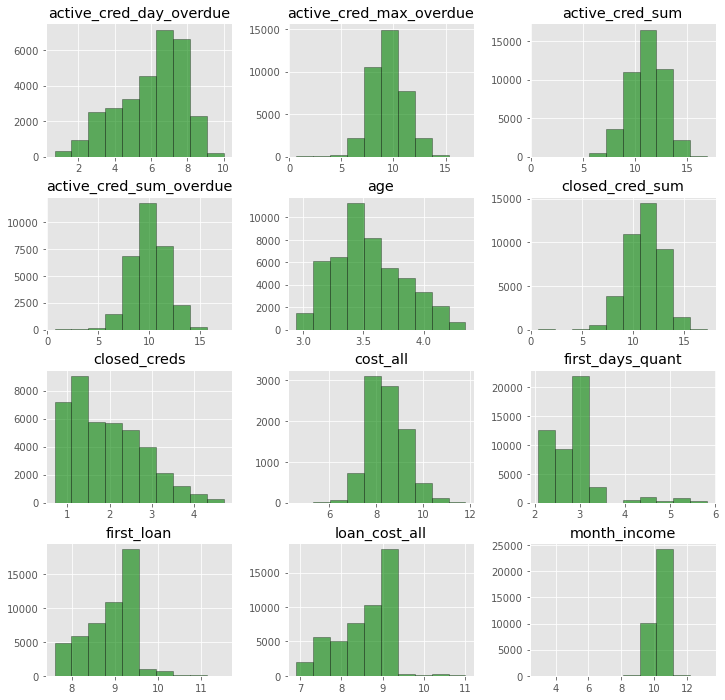

In [13]:
# распределения после удаления выбросов
df_c[num_cols].hist(edgecolor = 'black', color = 'green', alpha = .6, figsize = (12, 12));

#### категориальные признаки

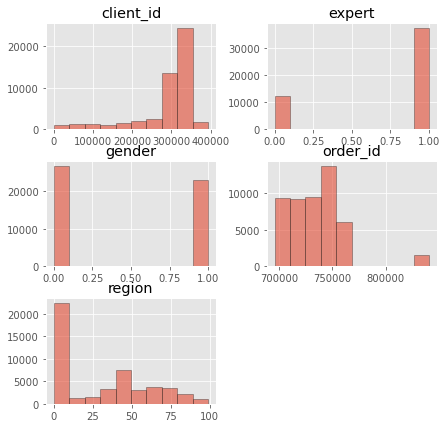

In [14]:
df_c_cat = df_c.drop(num_cols, 1)
df_c_cat.hist(edgecolor = 'black', alpha = .6, figsize = (7, 7));

In [15]:
# регион 0, похоже, является пропуском
df_c['region'] = df_c['region'].replace({0:np.nan})

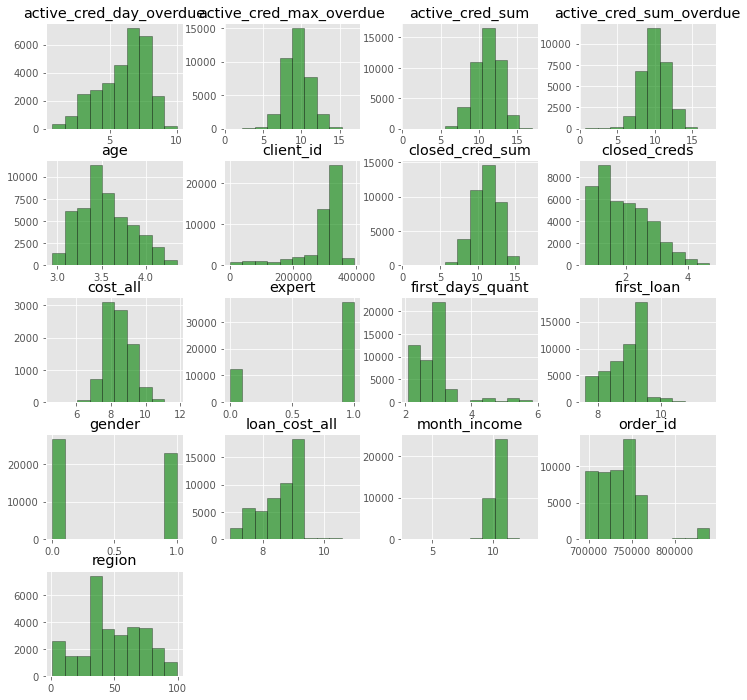

In [16]:
df_c.hist(edgecolor = 'black', alpha = .6, figsize = (12, 12), color = 'green');

### целевая переменная

In [17]:
# отсортируем по дате
df_c = df_c.sort_values('order_date')

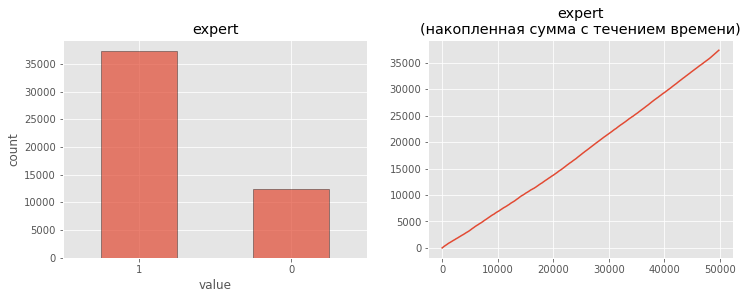

In [18]:
plt.figure(figsize = (12, 4))

ax1 = plt.subplot(1, 2, 1)
target_bar = df_c['expert'].value_counts().plot(ax = ax1, kind = 'bar', edgecolor = 'black', alpha = .7)
plt.title('expert')
target_bar.set_xticklabels(target_bar.get_xticklabels(), rotation = 0)
plt.xlabel('value')
plt.ylabel('count')

ax2 = plt.subplot(1, 2, 2)
df_c['expert'].cumsum().reset_index(drop = True).plot(ax = ax2)
plt.title('expert\n(накопленная сумма с течением времени)')
plt.show()

In [19]:
X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(df_c.drop('expert', 1), df_c['expert'],\
                                                    stratify = df_c['expert'], test_size = .2, random_state = SEED)

### тестируем трейн и тест выборки на идентичность распределений
* используем парный тест колмогорова-смирнова
* h0 - выборки взяты из одного распределения


In [20]:
alpha = .05

for _ in tqdm_notebook(range(1000)):
    X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(df_c.drop('expert', 1), df_c['expert'],\
                                                        stratify = df_c['expert'], test_size = .1, random_state = _)

    results = []
    for i, col in enumerate(X_TR.drop('order_date', 1).columns):
        if ks_2samp(X_TR[col], X_HOLDOUT[col])[1] < alpha:
            results.append(False)
        else:
            results.append(True)

    all_trues = np.all(np.array(results) == True)   
    if all_trues:
        seed = _
        flags = np.array(results)
        break
        

In [21]:
X_TR, X_HOLDOUT, Y_TR, Y_HOLDOUT = train_test_split(df_c.drop('expert', 1), df_c['expert'],\
                                                    stratify = df_c['expert'], test_size = .1, random_state = seed)

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
lgb_clf = LGBMClassifier(random_state =SEED)

nsplits, nrepeats = 5, 1
nfolds = nsplits*nrepeats
rskf5 = RepeatedStratifiedKFold(n_splits=nsplits, n_repeats=nrepeats, random_state = SEED)

In [23]:
X_TR['month'] = X_TR['order_date'].dt.month
X_TR['day'] =X_TR['order_date'].dt.day
X_TR['dayofweek'] = X_TR['order_date'].dt.dayofweek

X_HOLDOUT['month'] = X_HOLDOUT['order_date'].dt.month
X_HOLDOUT['day'] =X_HOLDOUT['order_date'].dt.day
X_HOLDOUT['dayofweek'] = X_HOLDOUT['order_date'].dt.dayofweek

df_c['month'] = df_c['order_date'].dt.month
df_c['day'] =df_c['order_date'].dt.day
df_c['dayofweek'] = df_c['order_date'].dt.dayofweek

In [24]:
X_TR = X_TR.drop('order_date', 1)
X_HOLDOUT = X_HOLDOUT.drop('order_date', 1)
df_c = df_c.drop('order_date', 1)

In [25]:
def _select_features(clf, _xtr, _ytr, cv, metric):
    
    '''
    Отбирает признаки 
    
    Параметры:
        1) clf - модель
        2) _xtr - признаки
        3) _ytr - таргет
        4) cv - схема валидации
    
    Возвращает:
        лучшее значение метрики, лучший набор признаков
    '''
    
    xtr, ytr = np.array(_xtr), np.array(_ytr)
    # валидируем каждый признак
    scores = []
    for i in tqdm_notebook(range(xtr.shape[1])):
        scores.append(cross_validate(clf, xtr[:, i].reshape(-1,1),\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean())
    # сортируем индивидуальные скоры в порядке убывания
    order = np.argsort(scores)[::-1]
    # лучший скор, лучшие признаки, признаки для проверки, счетчик ранней остановки
    best_score, best_features, to_drop = .5, [], []
    # по признакам в порядке убывания индивидуальных скоров
    for i in tqdm_notebook(order):
        # добавляем признак в список лучших
        current_features = best_features+[i]
        # считаем валидацю
        mean_score = cross_validate(clf, xtr[:, current_features],\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean()
        # если есть улучшение
        if mean_score > best_score:
            # обновляем лучший скор
            best_score = mean_score
            # обновляем лучшие признаки
            best_features = current_features            
        # если улчшения нет
        else:
            # добавляем признак в кандидаты на удаление
            to_drop.append(i)
            
    # списки на удаление признаков ДО и ПОСЛЕ отбора
    to_drop_before = to_drop
    to_drop_after = []
    # запускаем бесконечный цикл
    while True:
        # добавляем последовательно признаки из кандидатов на удаление
        for i in tqdm_notebook(to_drop_before):
            current_features = best_features+[i]
            mean_score = cross_validate(clf, xtr[:, current_features],\
                                     ytr, scoring =metric, cv = cv)['test_score'].mean()
            # если есть улучшение скора
            if mean_score > best_score:
                # обновляем лучший скор
                best_score = mean_score
                # обновляем лучшие признаки
                best_features = current_features            
            else:
                # добавляем признак в кандидаты на удаление ПОСЛЕ
                to_drop_after.append(i)
        # если списки ДО и ПОСЛЕ отличаются меньше, чем на 5 признаков 
        if len(to_drop_before) == len(to_drop_after):
            # останавливаем отбор
            break            
        else:
            # ДО --> ПОСЛЕ, ПОСЛЕ - пустой
            to_drop_before = to_drop_after
            to_drop_after = []
            
            
    return (best_score, best_features)

In [26]:
%%time

results_L = []
# используем метрику
for metric in tqdm_notebook(['roc_auc', 'f1', 'accuracy', 'precision', 'recall']):
    # отбираем признаки
    best_score, best_features = _select_features(lgb_clf, X_TR, Y_TR, cv = rskf5, metric=metric)    
    results_L.append((metric, best_score, best_features))
results_L = np.array(results_L)[np.argsort([r[1] for r in results_L])[::-1]]



Wall time: 3min 26s


In [27]:
print('{:<10} | {} | {} | {}'.format('метрика', 'валидация', 'число использованных признаков', 'всего признаков'))
print('---------------------------------------------------------------------------')
for el in results_L:
    print('{:<10} | {:<9.5f} | {:<30} | {}'.format(el[0], el[1], len(el[2]), X_TR.shape[1]))

метрика    | валидация | число использованных признаков | всего признаков
---------------------------------------------------------------------------
recall     | 1.00000   | 1                              | 19
roc_auc    | 0.99758   | 16                             | 19
f1         | 0.99245   | 5                              | 19
accuracy   | 0.98860   | 4                              | 19
precision  | 0.98822   | 13                             | 19


In [28]:
from sklearn.metrics import confusion_matrix
predictions_df = pd.DataFrame(index = X_TR.index)
for el in tqdm_notebook(results_L):
    if el[1]!='roc_auc':        
        for tr_idx,val_idx in rskf5.split(X_TR, Y_TR):    
            xtr, xval = X_TR.iloc[tr_idx, el[2]], X_TR.iloc[val_idx, el[2]]
            ytr, yval = Y_TR.iloc[tr_idx], Y_TR.iloc[val_idx]
            lgb_clf.fit(xtr, ytr)
            ypred = lgb_clf.predict(xval)
            predictions_df.loc[X_TR.index[val_idx], 'optimize_'+el[0]] = ypred
            
    else:        
        for tr_idx,val_idx in rskf5.split(X_TR, Y_TR):    
            xtr, xval = X_TR.iloc[tr_idx, el[2]], X_TR.iloc[val_idx, el[2]]
            ytr, yval = Y_TR.iloc[tr_idx], Y_TR.iloc[val_idx]
            lgb_clf.fit(xtr, ytr)
            ypredprob = lgb_clf.predict_proba(xval)[:, 1]
            predictions_df.loc[X_TR.index[val_idx], 'optimize_auc'] = ypredprob

In [29]:
predictions_df.nunique()

optimize_recall       1
optimize_roc_auc      2
optimize_f1           2
optimize_accuracy     2
optimize_precision    2
dtype: int64

In [30]:
# оставляем полезные метрики
predictions_df = predictions_df.drop(['optimize_recall', 'optimize_roc_auc'],1)

In [31]:
# 0 - кредит одобрен, 1- кредит отклонен
X_TR[predictions_df.columns] = predictions_df

In [32]:
report_df = X_TR[['cost_all', 'loan_cost_all']+predictions_df.columns.tolist()]
report_df['expert'] = Y_TR

# кредит одобрили & выплат не было 
report_df2 = report_df[(report_df['expert'] == 0) & (report_df['cost_all'].isna())]

In [33]:
print('оптимизация f1, убыток = {:.0f}'.format(report_df2[report_df2['optimize_f1'] == 1]['loan_cost_all'].sum()))
print('оптимизация accuracy, убыток = {:.0f}'.format(report_df2[report_df2['optimize_accuracy'] == 1]['loan_cost_all'].sum()))
print('оптимизация precision, убыток = {:.0f}'.format(report_df2[report_df2['optimize_precision'] == 1]['loan_cost_all'].sum()))



оптимизация f1, убыток = 3932
оптимизация accuracy, убыток = 3905
оптимизация precision, убыток = 3343


### precision - наилучшая метрика

In [83]:
np.random.seed(SEED)
N_SAMPLES, SAMPLE_SIZE, ALPHA = 100, 100, .05
for col in X_TR.columns:
    val1 = X_TR[col][Y_TR==1].values
    val0 = X_TR[col][Y_TR!=1].values    
    bt_means_1 = np.mean(np.random.choice(val1, (N_SAMPLES, SAMPLE_SIZE)), 1)
    bt_means_2 = np.mean(np.random.choice(val0, (N_SAMPLES, SAMPLE_SIZE)), 1)
    alpha = stats.ttest_ind(bt_means_1, bt_means_2)[1]
    if alpha>ALPHA:
        print('Средние разные в {} на уровне значимости {:.0%}'.format(col, 1-ALPHA))
        

Средние разные в dayofweek на уровне значимости 95%


In [84]:
'dayofweek' in X_TR.columns[results_L[-1][2]]

True

In [85]:
import category_encoders as ce
from sklearn.model_selection import KFold
to_enc = 'dayofweek'

_X_TR = X_TR.iloc[:, results_L[-1][2]]
_X_HOLDOUT = X_HOLDOUT[_X_TR.columns]
df_c = df_c[_X_TR.columns]

encoder1 = ce.TargetEncoder(min_samples_leaf=5,cols= ['dayofweek'])
encoder2 = ce.CatBoostEncoder(cols= ['dayofweek'])

In [86]:
best_score = cross_validate(lgb_clf, _X_TR, Y_TR, scoring ='precision', cv = rskf5)['test_score'].mean()

In [87]:
lgb_clf.fit(_X_TR, Y_TR)
best_holdout = precision_score(Y_HOLDOUT, lgb_clf.predict(_X_HOLDOUT))

In [88]:
encs_tr_L, enc_holdout_L, enc_full_L = [], [], []
for nfolds in tqdm_notebook([3, 5, 7, 9, 11, 20]):
    
    encs_tr = pd.DataFrame(index = Y_TR.index, columns = ['enc1', 'enc2'])
    encs_holdout = pd.DataFrame(index = Y_HOLDOUT.index, columns = ['enc1', 'enc2']).fillna(0.0)
    encs_full = pd.DataFrame(index = df_c.index, columns = ['enc1', 'enc2']).fillna(0.0)
    for tr_idx, val_idx in KFold(nfolds, random_state = SEED).split(X_TR, Y_TR):

        encoder1.fit(_X_TR.iloc[tr_idx], Y_TR.iloc[tr_idx])
        encoder2.fit(_X_TR.iloc[tr_idx], Y_TR.iloc[tr_idx])
        
        encs_tr.loc[_X_TR.iloc[val_idx].index, 'enc1'] = encoder1.transform(_X_TR.iloc[val_idx])[to_enc].values
        encs_tr.loc[_X_TR.iloc[val_idx].index, 'enc2'] = encoder2.transform(_X_TR.iloc[val_idx])[to_enc].values

        encs_holdout.loc[_X_HOLDOUT.index, 'enc1'] += encoder1.transform(_X_HOLDOUT)[to_enc].values / nfolds
        encs_full.loc[df_c.index, 'enc1'] += encoder1.transform(df_c)[to_enc] / nfolds

        encs_holdout.loc[_X_HOLDOUT.index, 'enc2'] += encoder2.transform(_X_HOLDOUT)[to_enc].values   / nfolds
        encs_full.loc[df_c.index, 'enc2'] += encoder2.transform(df_c)[to_enc] / nfolds
    
    
    encs_tr_L.append(encs_tr)
    enc_holdout_L.append(encs_holdout)
    enc_full_L.append(encs_full)

In [89]:
for i in tqdm_notebook(range(len(encs_tr_L))):
    
    # добавляем кодирования
    _X_TR1 = pd.concat([_X_TR, encs_tr_L[i].astype(float)], 1)
    _X_HOLDOUT1 = pd.concat([_X_HOLDOUT, enc_holdout_L[i].astype(float)], 1)
    _df_c1 = pd.concat([df_c, enc_full_L[i]], 1)
    
    # отбираем признаки
    cv, best_features = _select_features(lgb_clf, _X_TR1, Y_TR, cv = rskf5, metric='precision')   
    _X_TR1_selected = _X_TR1.iloc[:, best_features]
    _X_HOLDOUT1_selected = _X_HOLDOUT1.iloc[:, best_features]
    _df_c1_selected = _df_c1.iloc[:, best_features]
    
    # получаем метрику на отложенной
    lgb_clf.fit(_X_TR1_selected, Y_TR)    
    holdout = precision_score(Y_HOLDOUT, lgb_clf.predict(_X_HOLDOUT1_selected))
    
    if (cv>best_score) & (holdout>best_holdout):
        best_score = cv
        best_holdout = holdout
        best_df = _df_c1_selected
        print(best_score, best_holdout)
        
        

In [101]:
print('precision(влидация) = {}'.format(best_score))
print('precision(отложенная) = {}'.format(best_holdout))

precision(влидация) = 0.9882214039326757
precision(отложенная) = 0.9875562615832671


In [96]:
from sklearn.model_selection import GridSearchCV

In [97]:
lgb_grid = GridSearchCV(lgb_clf,\
             param_grid = {'n_estimators' : [500], 'learning_rate' :[.05],\
                           'max_depth' : [3, 5, 7, 70, 80, 90],\
                           'num_leaves' : [4, 9, 16, 25, 36, 64, 128],
                           'min_child_samples': [20, 50, 100]},\
             scoring = 'precision', cv = rskf5)

In [107]:
y = df.loc[df_c.index, 'expert']
lgb_grid.fit(df_c, y)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=5, random_state=13),
             estimator=LGBMClassifier(random_state=13),
             param_grid={'learning_rate': [0.05],
                         'max_depth': [3, 5, 7, 70, 80, 90],
                         'min_child_samples': [20, 50, 100],
                         'n_estimators': [500],
                         'num_leaves': [4, 9, 16, 25, 36, 64, 128]},
             scoring='precision')

In [110]:
print('Валидация всего датасета, precision = {}'\
      .format(cross_validate(lgb_clf, df_c, y, scoring ='precision', cv = rskf5)['test_score'].mean()))

Валидация всего датасета, precision = 0.9880809254621388


In [112]:
print('Валидация всего датасета(оптимизация гиперпараметров), precision = {}'\
      .format(lgb_grid.best_score_))

Валидация всего датасета(оптимизация гиперпараметров), precision = 0.9905505920183328
